In [1]:
#Import the packages to be used

import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics as sklm
from sklearn import preprocessing
from sklearn import linear_model
import scipy.stats as ss
import seaborn as sns
import math

#Make plot appear inline in rthe notebook
%matplotlib inline

Text(0.5,1,'Data for Regression')

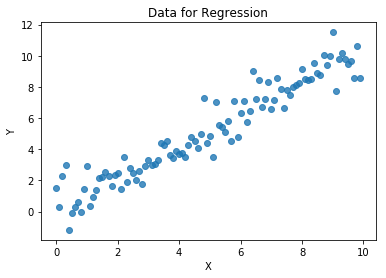

In [2]:
#Simulate Data & plot results

nr.seed(34567)   #set seed for random generation
x = np.arange(start = 0.0, stop = 10.0, step = 0.1)   #uniformly b/w 0.0 & 10.0
y = np.add(x, nr.normal(scale = 1.0, size = x.shape[0]))   #x-variable + Normally distributed random component. Thus slope coeff. should be 1.0 & intercept coeff. is 0.0.

sns.regplot(x, y, fit_reg = False)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data for Regression')

In [3]:
#Split data set into independent training and test sets via random Bernoulli sampling
 #The probability the case is in training set = p & the probablity the case is in the test set = 1-p.

nr.seed(9988)   #set random seed
indx = range(len(x))
indx = ms.train_test_split(indx, test_size = 50) #Splits set into features & label valuesv into numpy array via Bernoulli sampling from sklearn.model_selection module
x_train = np.ravel(x[indx[0]])
y_train = np.ravel(y[indx[0]])
x_test = np.ravel(x[indx[1]])
y_test = np.ravel(y[indx[1]])

In [4]:
#Scale Numeric Features - always on training data but never on test or evaluation 
 #data (numeric labels don't need to be scaled, though might require other transformations)
  #Min-Max Normalization - xscaled = ((xi-Minx)/(Maxx-Minx)), usually good for for complex
    #distributions,such as multiple modes. Outliers might distort overall.
  #Z-Score Normalization - xscaled = ((xi-u)/sigma), which transforms to a mean=0 and unit 
    #std. dev./variance, where u is mean of variable X, sigma is std. dev. of variable X.

#Scale feature only (not test data)
scaler = preprocessing.StandardScaler().fit(x_train.reshape(-1,1))   #Computes scaling coeff. for train set using sklearn.preprocessing package
x_train = scaler.transform(x_train.reshape(-1,1))
y_train = scaler.transform(y_train.reshape(-1,1))

In [5]:
#Training Regression Model
  #1) Instantiate model object, additional model specs. can be done at this time.
  #2) Use numpy array of feature and label to fit model. Reshape is used to make correct dimension of array feature

lin_mod = linear_model.LinearRegression()
lin_mod.fit(x_train.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
#Print both slope and intercept coeff. to confirm they are near 1 & 0, respectively.
print(lin_mod.intercept_)   #Print intercept coeff.
print(lin_mod.coef_)   #Print slope coeff.

[0.08516893]
[[1.03285118]]


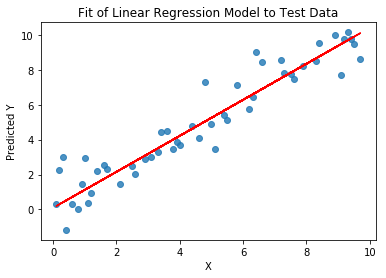

In [7]:
#Plot predicted values from Test Set using Training Features

def plot_regression(x, y_score, y): 
    sns.regplot(x, y, fit_reg = False)   #plot the resulting values using Seaborn
    plt.plot(x, y_score, c = 'red')
    plt.xlabel('X')
    plt.ylabel('Predicted Y')
    plt.title('Fit of Linear Regression Model to Test Data')
    
y_score = lin_mod.predict(x_test.reshape(-1,1))  #Line of predicted values or scores

plot_regression(x_test, y_score, y_test)

In [8]:
#Red line looks to be a good fit with minimal residuals, but an evaluation is needed.

#Evaluate common metric using sklearn.metrics

def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
    
print_metrics(y_test, y_score, 2)    

Mean Square Error      = 1.0178480188322825
Root Mean Square Error = 1.008884541873986
Mean Absolute Error    = 0.763059846639255
Median Absolute Error  = 0.6031435928079797
R^2                    = 0.8979014436983853
Adjusted R^2           = 0.8957743904421017


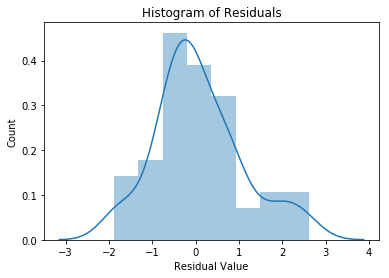

In [11]:
#Above- MSE & RMSE both near 1.0, as expected for simulated standard deviation. MAE & median absolute error
 # are close to each other w/ small values, indicating a good model fit w/ few significant outliers in residuals.
 # R^2 & R^2 adjusted are both close to 1.0, indicating model is making useful predictions which are better than avg of label values.

#Below- Check for normal distributions using a histogram using pyplot and seaborn

def hist_resids(y_test, y_score):
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))  #Compute vector of residuals
    sns.distplot(resids)  # make residual plots
    plt.title ('Histogram of Residuals')
    plt.xlabel('Residual Value')
    plt.ylabel('Count')
                     
hist_resids(y_test, y_score)

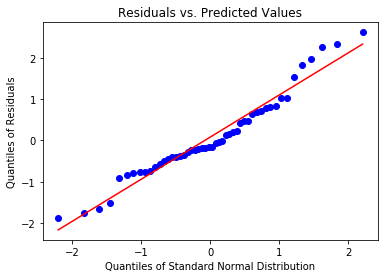

In [12]:
#Above- Overall, the histogram & distribution density plot look approx. normal, but w/ slight deviation, bimodal?
 #This looks reasonable for real-world model
    
#Below- Check for normal distribution using a Quantile-Quantile (Q-Q) normal plot

def resid_qq(y_test, y_score):
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))  #compute vector of residuals
    ss.probplot(resids.flatten(), plot = plt)  #make residual plots
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Quantiles of Standard Normal Distribution')
    plt.ylabel('Quantiles of Residuals')
    
resid_qq(y_test, y_score)    

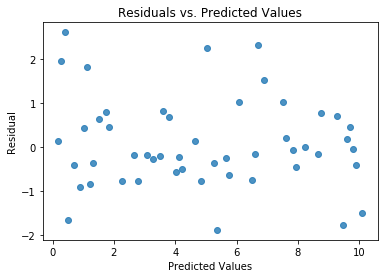

In [15]:
#Above- Residuals are almost a straight line, therefore distrib. is approx. normal.

#Below- Check for structure using a residual plot (residuals vs predicted values)
 #Ideally looks like a fuzzy catepillar with no change in predicted value (pv)
 #If residual increase w/ pv, model said to predict only smaller label values well
 #If residual decrease w/ pv, model said to predict only large label values well
 #If mid-section changes, there is some nonlinear change w/ pv, thus not accurately calculating predicted values


def resid_plot(y_test, y_score):
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))  # Compute vector of residuals
    sns.regplot(y_score, resids, fit_reg = False)   #make residual plots
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residual')
    
resid_plot(y_test, y_score)

In [ ]:
#Above- Dispersion is contact over range of pv, looks fairly well behaved.

#Summary-
 #Performed complete machine learning process for a linear regression
    #1) Simulated dataset w/ data exploration
    #2) Prepared data by splitting into training & test data subsets & scaling features as needed.
    #3) Used Scikit-Learn to construct regression model w/ training data
    #4) Evaluated results of model w/ test data by finding residuals were fairly small and well behaved.